# Lab 11 (Evaluable)

We work for one of the most popular car buying and selling platforms in the world. From the product team they want to introduce a price recommender for the user based on the qualities of the car they want to sell. They have asked the Data Science team to tackle the challenge including:
- An exhaustive analysis of the data of the vehicles introduced in the platform in the past.
- The development of a predictive pricing model.
- The creation of a streamlit app that allows you to view the results of the analysis and interact with the model.
- Adding an explainability tab to the app so that all users can understand why each price is recommended to them.

# Practice Information:
**Due date:** By end of November, 29th (23:55h)

**Submission procedure:** via Moodle.

**Name:** Nicolas Vila

**NIA:** 240230

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from random import seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
#from xgboost import XGBRegressor
import lightgbm as lgb
import pickle

import warnings
warnings.simplefilter('ignore')

sns.set_palette("icefire")

### Read the Data

In [ ]:
df = pd.read_csv("car_ad_display.csv", encoding = "ISO-8859-1", sep=";").drop(columns='Unnamed: 0')
df.head(3)

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear


## Data Gathering and Data Wrangling

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8849 entries, 0 to 8848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8849 non-null   object 
 1   price         8849 non-null   float64
 2   body          8849 non-null   object 
 3   mileage       8849 non-null   int64  
 4   engV          8849 non-null   float64
 5   engType       8849 non-null   object 
 6   registration  8849 non-null   object 
 7   year          8849 non-null   int64  
 8   model         8849 non-null   object 
 9   drive         8467 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 691.5+ KB


In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8467 entries, 0 to 8848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8467 non-null   object 
 1   price         8467 non-null   float64
 2   body          8467 non-null   object 
 3   mileage       8467 non-null   int64  
 4   engV          8467 non-null   float64
 5   engType       8467 non-null   object 
 6   registration  8467 non-null   object 
 7   year          8467 non-null   int64  
 8   model         8467 non-null   object 
 9   drive         8467 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 727.6+ KB


#### EX1: How many different entries do we have for the car names column?

In [ ]:
df['car'].nunique()

83

**Solution:** We have 83 different type of cars

#### Let's reduce the number of car names with a cutoff

In [ ]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

In [ ]:
car_map = shorten_categories(df.car.value_counts(), 10)
df['car'] = df['car'].map(car_map)
df.car.value_counts()

car
Volkswagen       833
Mercedes-Benz    772
BMW              611
Toyota           498
Renault          430
VAZ              426
Audi             403
Opel             368
Skoda            338
Hyundai          329
Ford             315
Mitsubishi       293
Nissan           281
Chevrolet        226
Daewoo           205
Kia              197
Honda            193
Mazda            173
Peugeot          167
Lexus            160
Land Rover       133
Fiat             110
Subaru           105
Citroen           94
Other             93
ZAZ               88
Porsche           82
Infiniti          60
Suzuki            53
Geely             50
Chery             47
Smart             44
SsangYong         43
Seat              36
Volvo             31
Jeep              25
Chrysler          22
GAZ               20
UAZ               18
Jaguar            18
MINI              15
Bentley           15
Acura             13
Dodge             13
Alfa Romeo        11
Dacia             10
Name: count, dtype: int64

#### EX2: Do the same with car model feature!

In [ ]:
model_map = shorten_categories(df.model.value_counts(), 10)
df['model'] = df['model'].map(model_map)
df.model.value_counts()

model
Other         1679
E-Class        178
A6             151
Camry          122
Vito ïàññ.     114
              ... 
Symbol          10
Sharan          10
S 550           10
207             10
Ibiza           10
Name: count, Length: 227, dtype: int64

#### EX3: Plot a bar char of the TOP 10 most expensive cars.
#### Which is the mean price per car brand?  (for the top 10 most expensive)

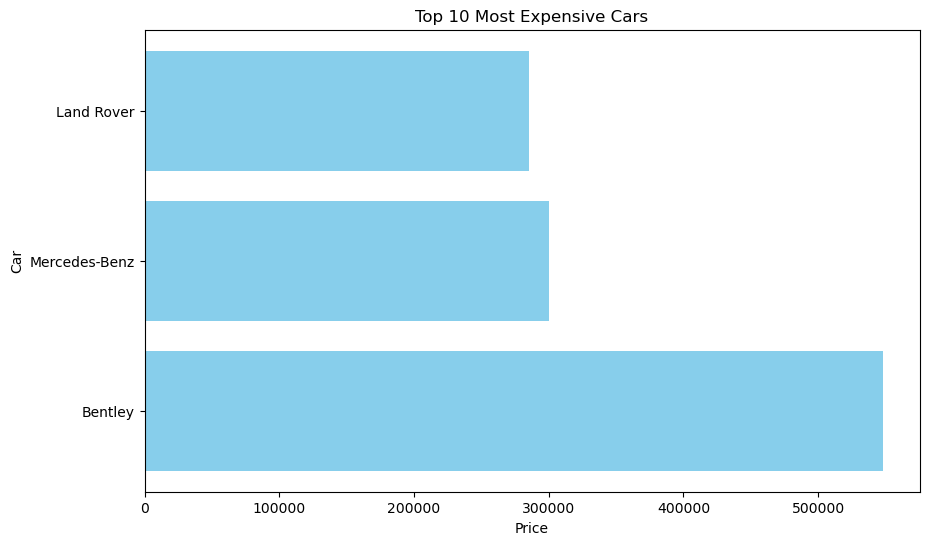

car
Bentley          451359.4
Land Rover       285000.0
Mercedes-Benz    285000.0
Name: price, dtype: float64


In [ ]:
top_10_expensive_cars = df.nlargest(10, 'price')
plt.figure(figsize=(10,6))
plt.barh(top_10_expensive_cars['car'], top_10_expensive_cars['price'], color='skyblue')
plt.xlabel('Price')
plt.ylabel('Car')
plt.title('Top 10 Most Expensive Cars')
plt.show()

# Mean price per car brand for the top 10 most expensive
mean_price_top_10 = top_10_expensive_cars.groupby('car')['price'].mean()
print(mean_price_top_10)

#### Let's analyze each variable distribution (except for car and model)

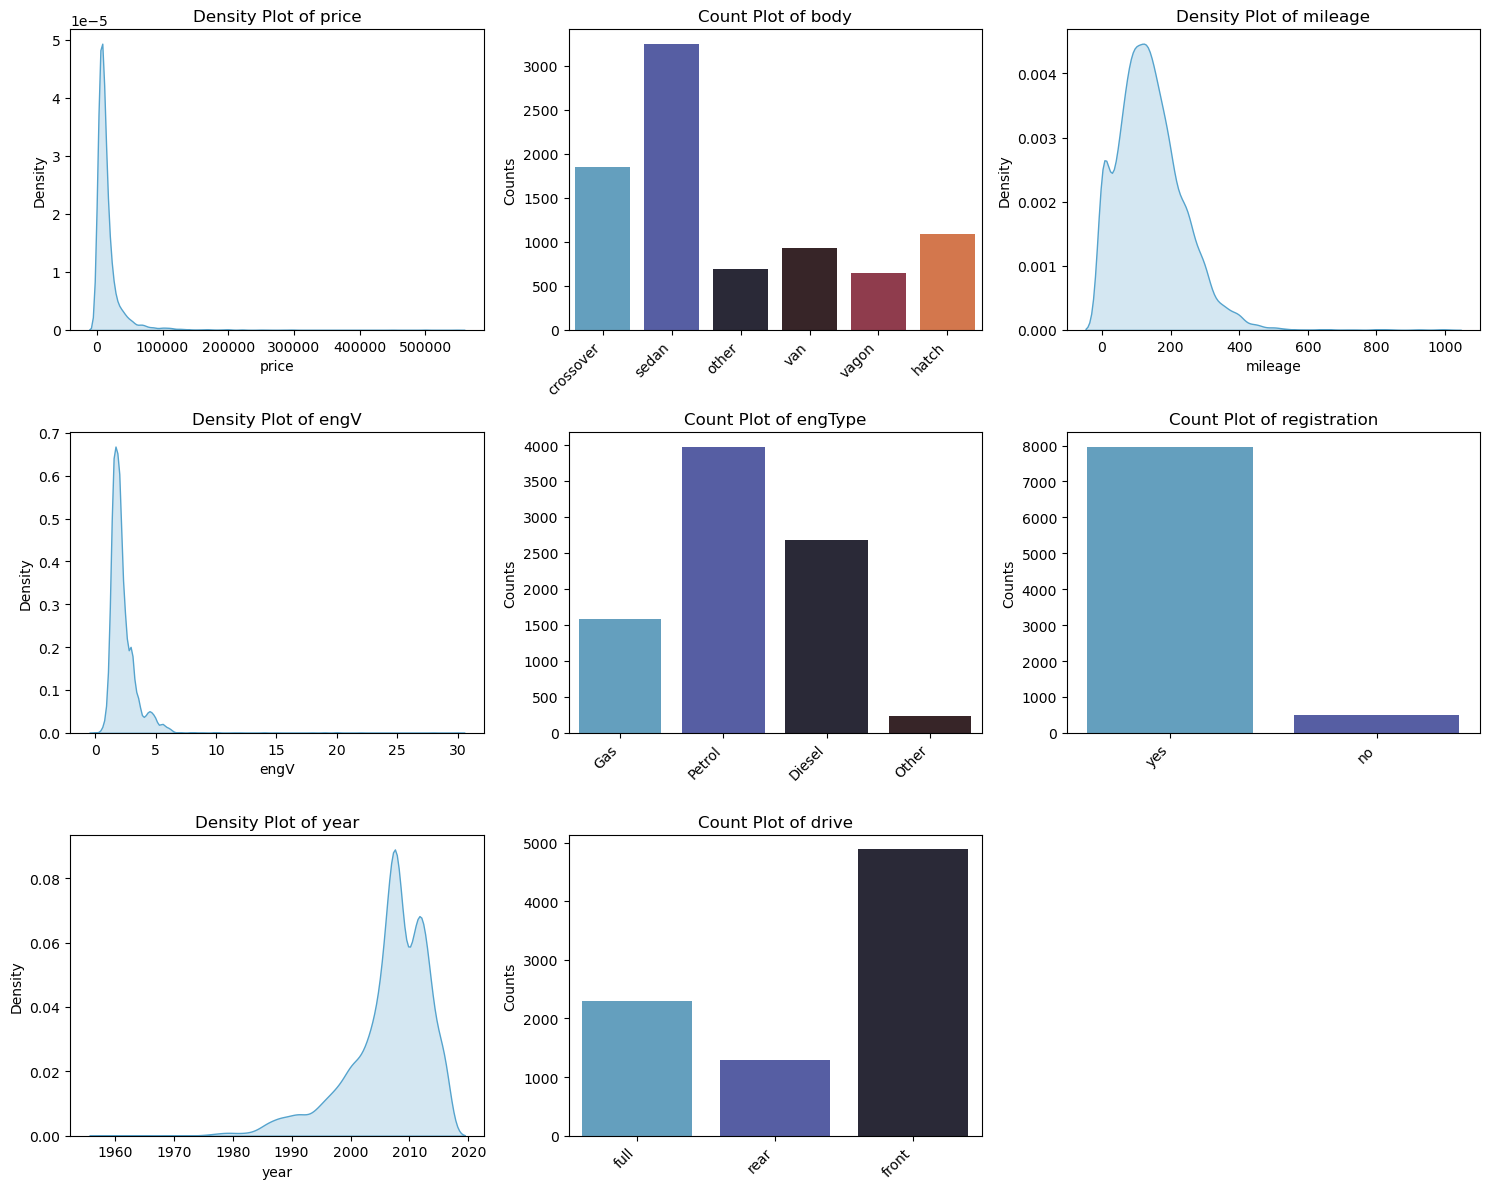

In [ ]:
# Define the type of plot for each column based on the data type
plot_types = {}
columns = [x for x in df.columns if x not in ["car", "model"]]

for col in columns:
    if df[col].dtype == 'object':  # Categorical columns
        plot_types[col] = 'bar'
    else:
        unique_values = df[col].nunique()
        if unique_values < 10:  # Discrete columns
            plot_types[col] = 'bar'
        else:  # Continuous columns
            plot_types[col] = 'kde'

n_cols = 3
n_rows = (len(columns) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Plot each column in the dataframe
for i, col in enumerate(columns):
    ax = axes[i]
    if plot_types[col] == 'bar':
        # For categorical and discrete data, use a count plot (bar chart)
        sns.countplot(x=col, data=df, ax=ax)
        ax.set_title(f'Count Plot of {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Counts')
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    else:
        # For continuous data, use a density plot
        sns.kdeplot(df[col], ax=ax, fill=True)
        ax.set_title(f'Density Plot of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

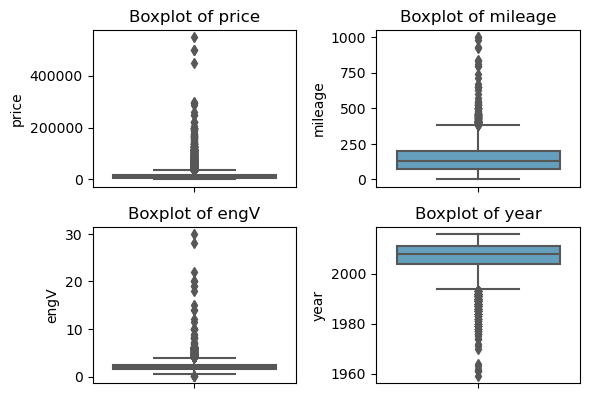

In [ ]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 2
n_rows = (len(numeric_columns) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

#### Let's analyze each variable behaviour with respect to the target (price)

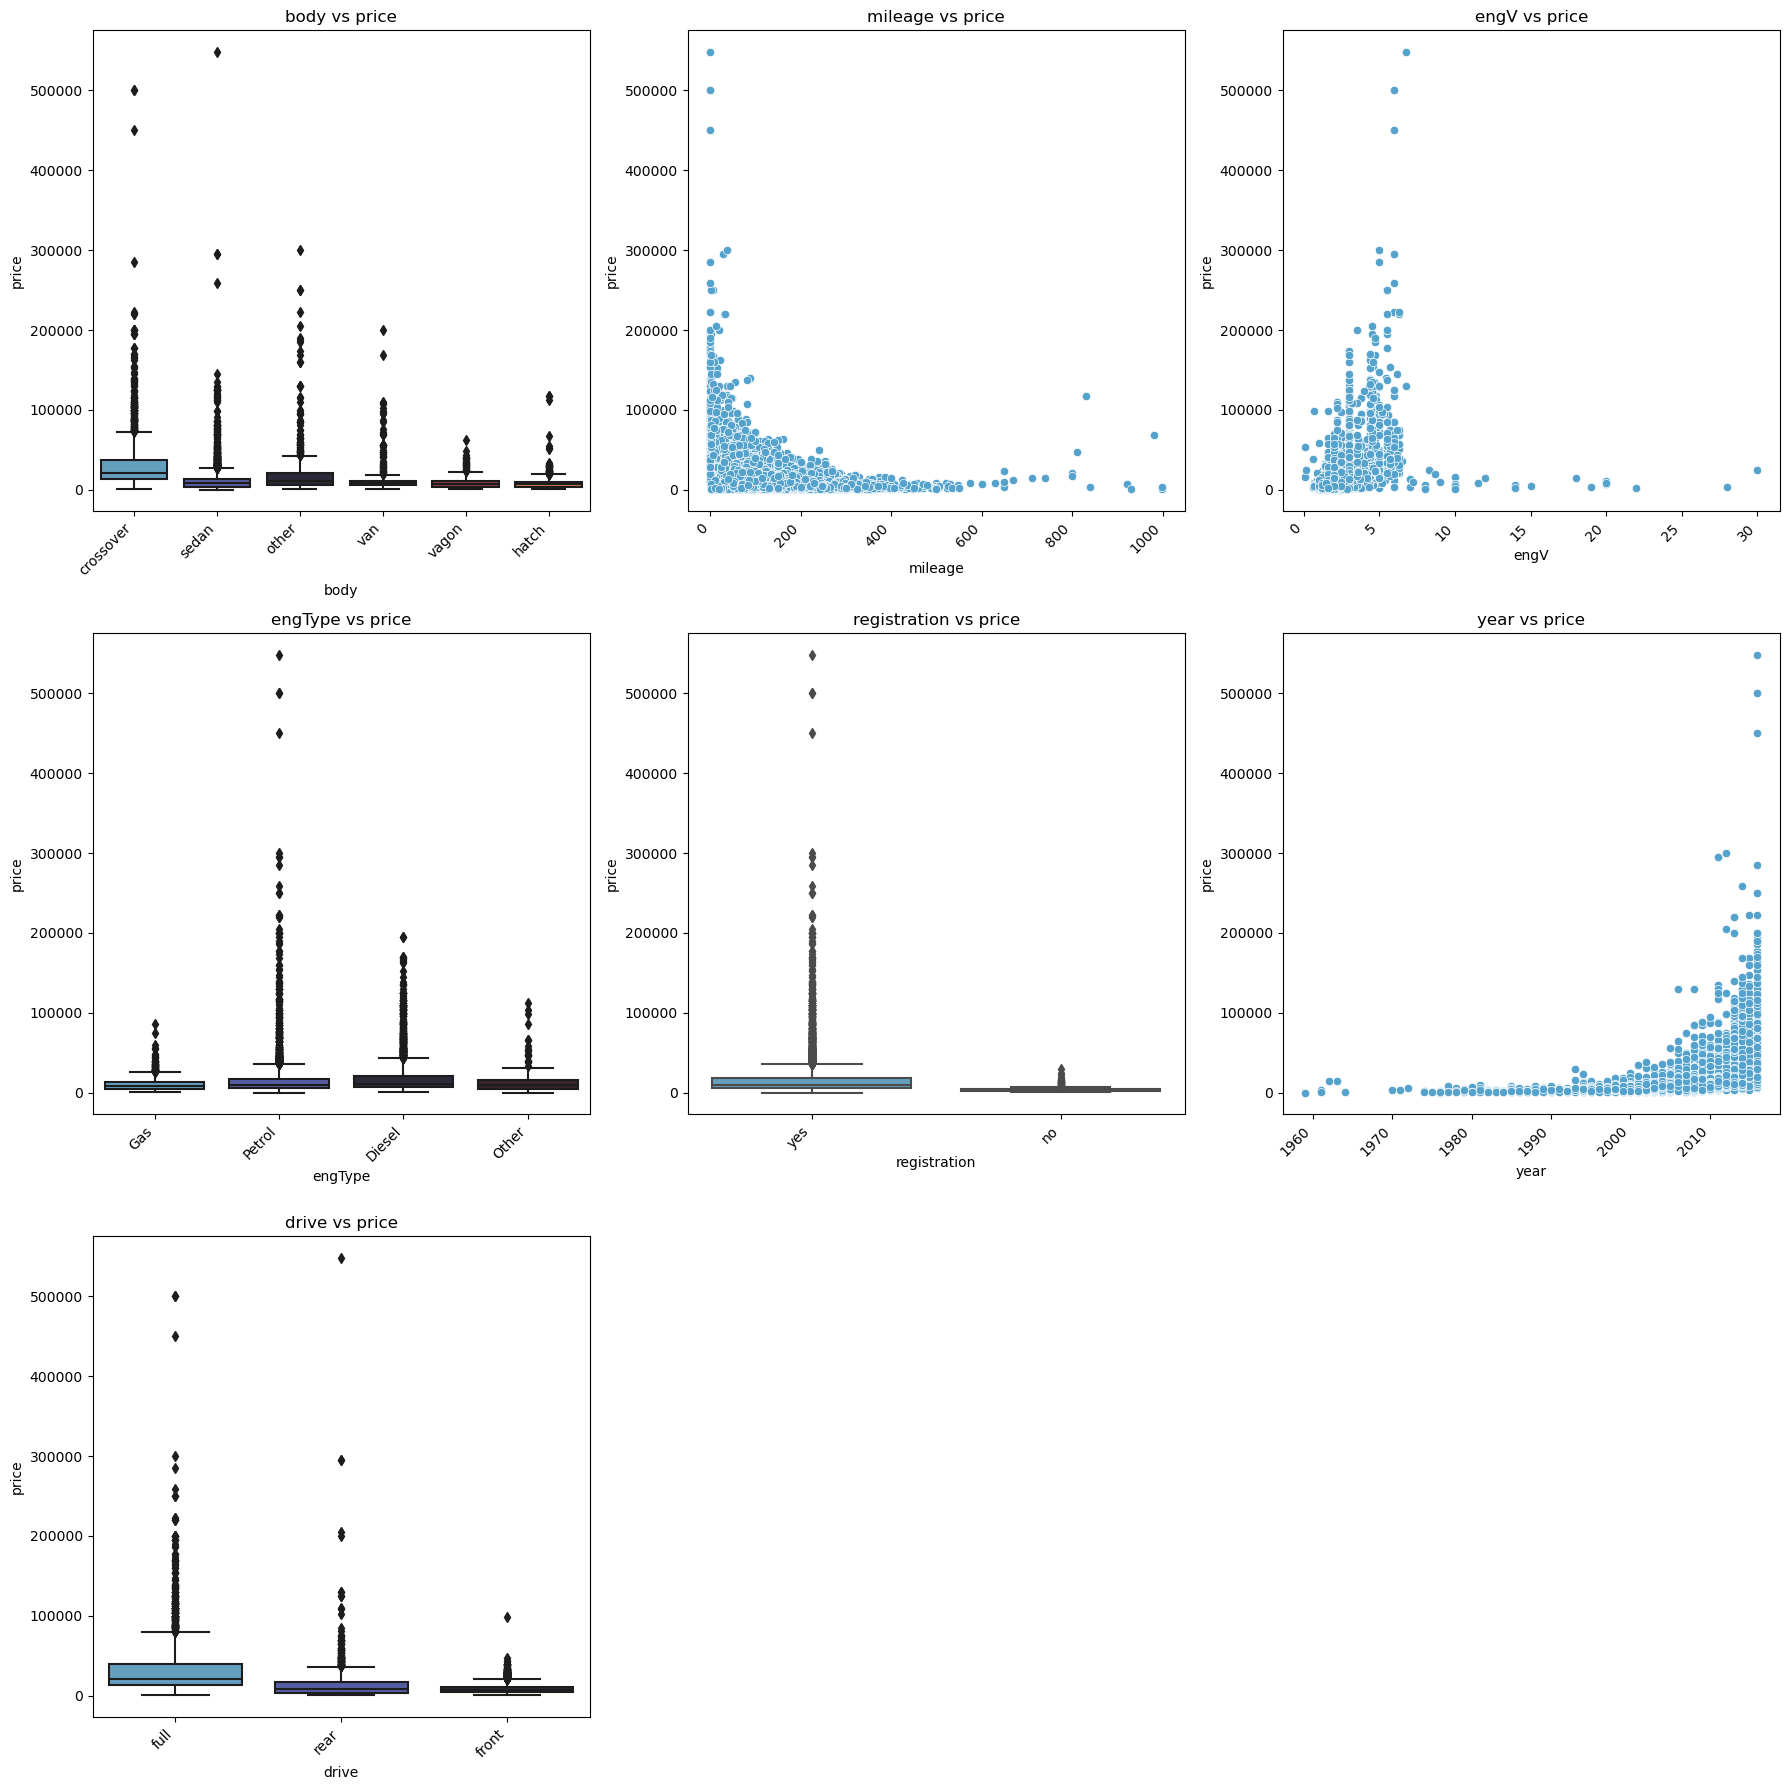

In [ ]:
target = 'price'
features = [x for x in df.columns if x not in ["car", "model", target]]

n_cols = 3
n_rows = (len(features) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()

# Plot each feature against the target variable in the dataframe
for i, feature in enumerate(features):
    ax = axes[i]
    if df[feature].dtype == 'object' or df[feature].nunique() < 10:
        # For categorical data, use a boxplot or violin plot
        sns.boxplot(x=feature, y=target, data=df, ax=ax)
    else:
        # For numerical data, use a scatter plot
        sns.scatterplot(x=feature, y=target, data=df, ax=ax)
    ax.set_title(f'{feature} vs {target}')
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

#### As we see, there are many outliers in the features and in the target data.
#### Let's get rid of outliers in the target

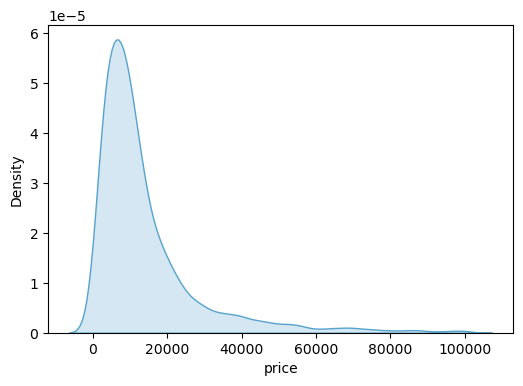

In [ ]:
#Let's filter the prices between 1K and 100K
df = df[df["price"] <= 100000]
df = df[df["price"] >= 1000]

plt.figure(figsize=(6, 4))
sns.kdeplot(x="price", data=df, fill=True)
ax.set_title(f'Count Plot of Price')
plt.show()

#### Let's get rid of outliers in the rest of the numeric features

In [ ]:
#Let's filter the mileage over 600
df = df[df["mileage"] <= 600]

#Let's filter the engV over 7.5
df = df[df["engV"] <= 7.5]

#Let's filter the year over 1975
df = df[df["year"] >= 1975]

#### Check how the behaviour of the features with the target has changed

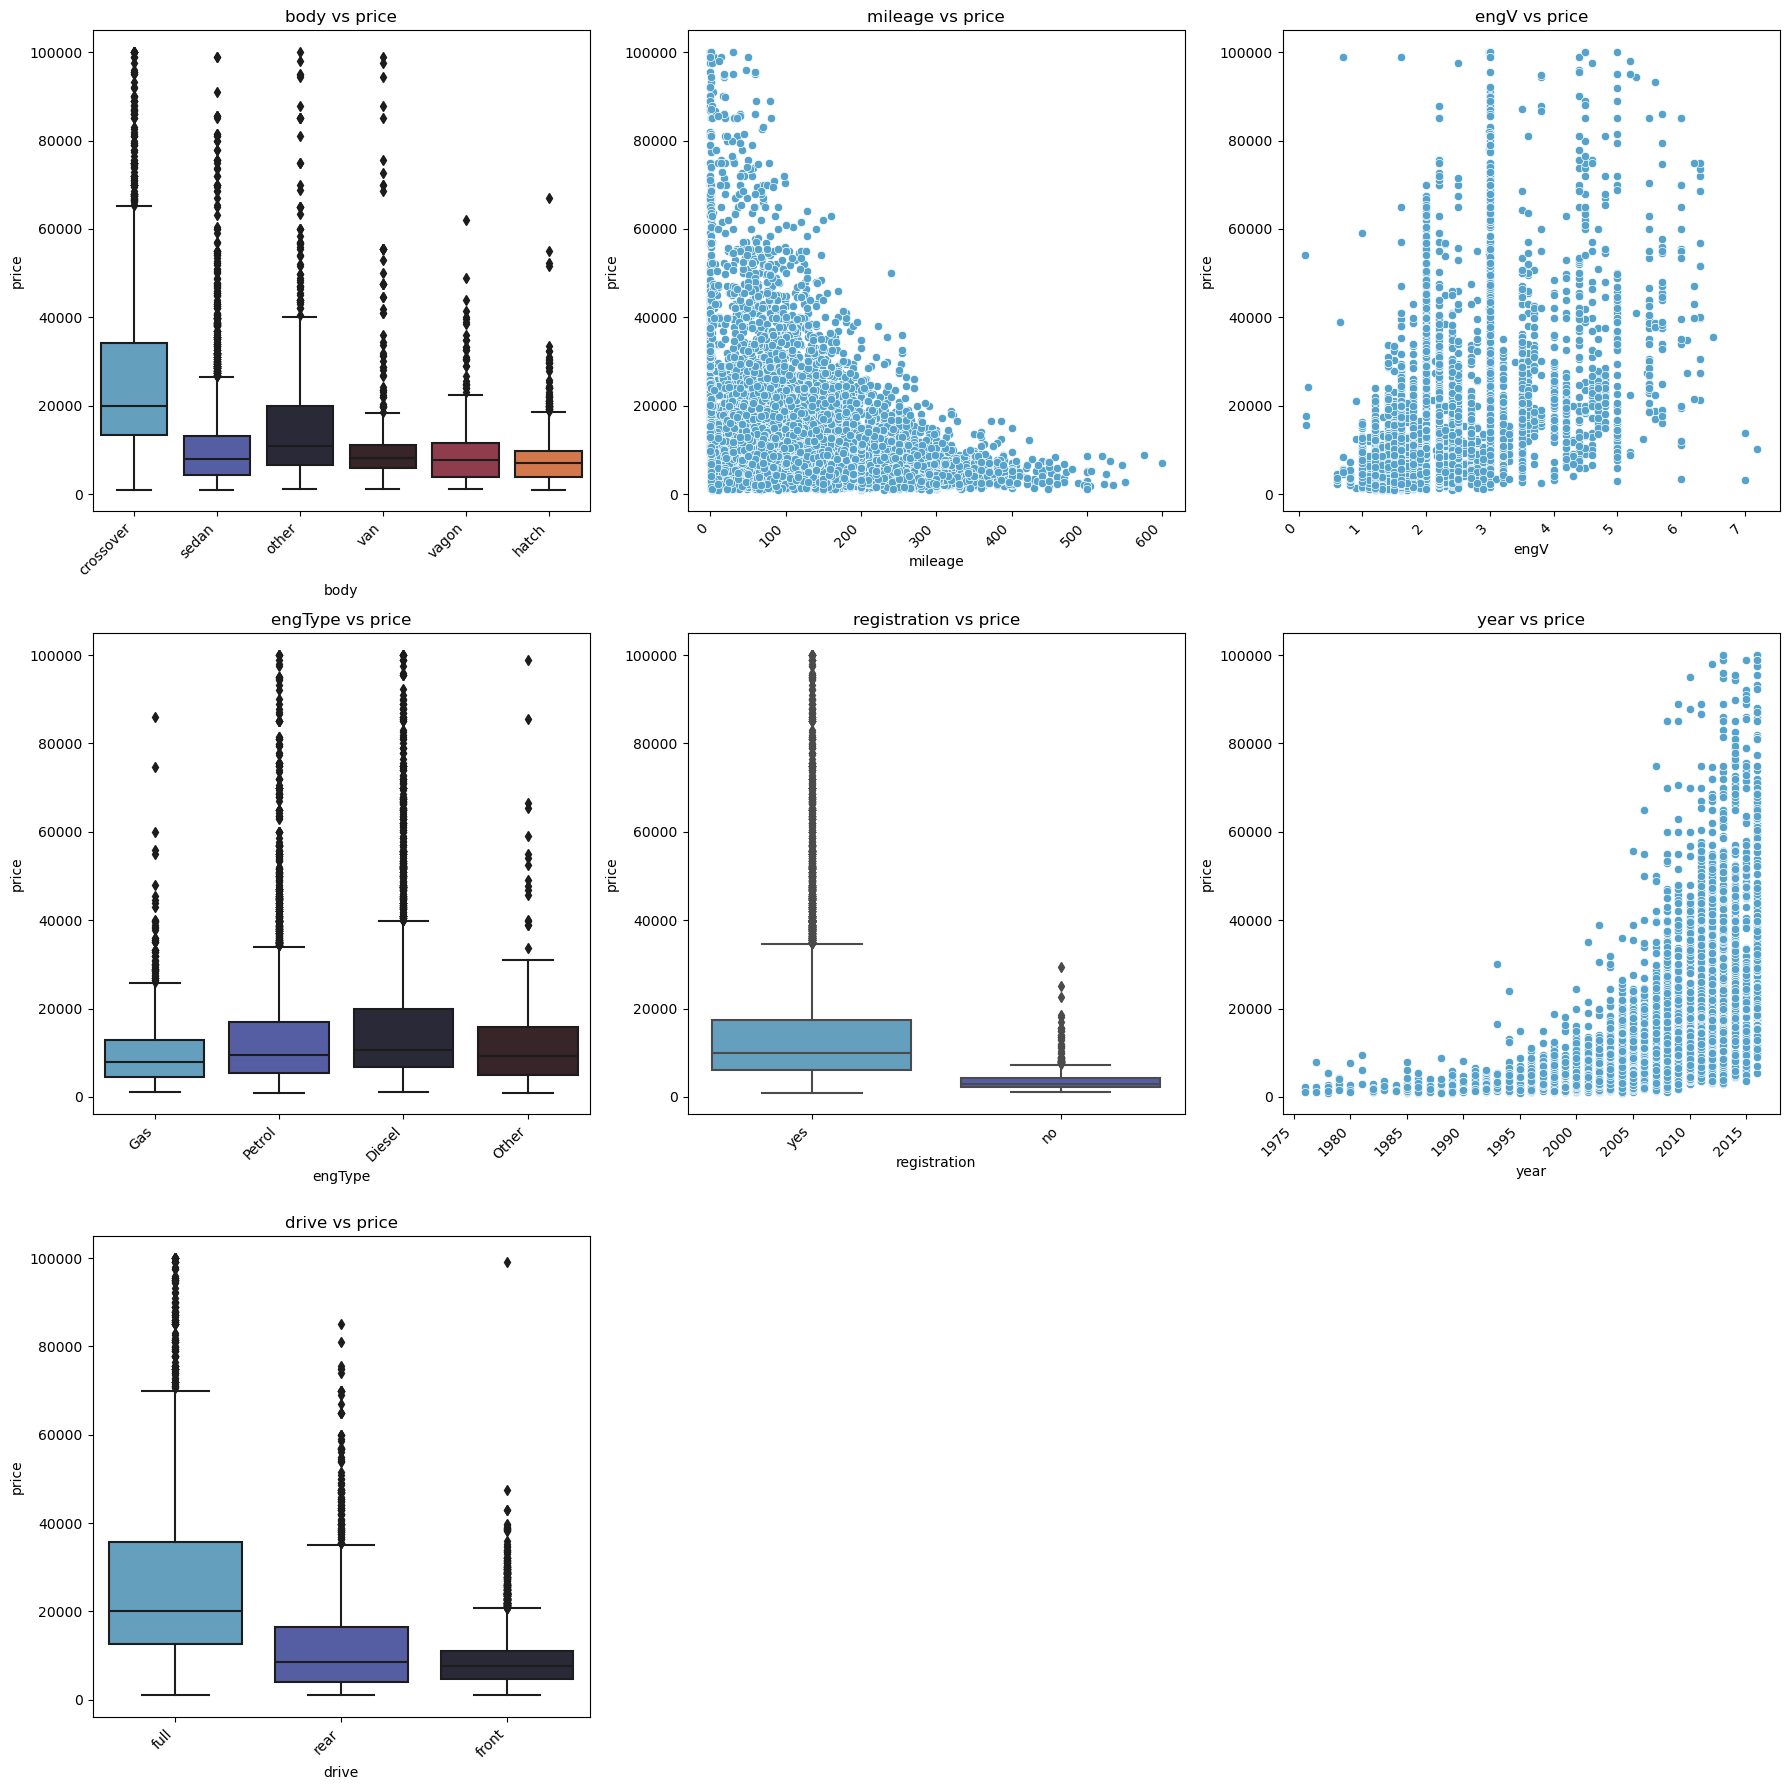

In [ ]:
target = 'price'
features = [x for x in df.columns if x not in ["car", "model", target]]

n_cols = 3
n_rows = (len(features) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()

# Plot each feature against the target variable in the dataframe
for i, feature in enumerate(features):
    ax = axes[i]
    if df[feature].dtype == 'object' or df[feature].nunique() < 10:
        # For categorical data, use a boxplot or violin plot
        sns.boxplot(x=feature, y=target, data=df, ax=ax)
    else:
        # For numerical data, use a scatter plot
        sns.scatterplot(x=feature, y=target, data=df, ax=ax)
    ax.set_title(f'{feature} vs {target}')
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

#### EX4: Which of the features do you predict would be more important for estimating the price?

**Solution:** It seems like there is a highest correlations with price are between mileage, year, and drive. 

#### EX5: After all changes, How many rows are left?

In [ ]:
len(df)


8224

**Solution:**  There are 8224 rows left

### Let's prepare the data for model:

In [ ]:
df_original = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8224 entries, 0 to 8848
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8224 non-null   object 
 1   price         8224 non-null   float64
 2   body          8224 non-null   object 
 3   mileage       8224 non-null   int64  
 4   engV          8224 non-null   float64
 5   engType       8224 non-null   object 
 6   registration  8224 non-null   object 
 7   year          8224 non-null   int64  
 8   model         8224 non-null   object 
 9   drive         8224 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 706.8+ KB


In [ ]:
#Let's encode the string features:

le_car = LabelEncoder()
df['car'] = le_car.fit_transform(df['car'])
print('*CAR: \n', df["car"].unique(), '\n')

le_body = LabelEncoder()
df['body'] = le_body.fit_transform(df['body'])
print('*BODY: \n', df["body"].unique(), '\n')

le_engType = LabelEncoder()
df['engType'] = le_engType.fit_transform(df['engType'])
print('*EngType: \n', df["engType"].unique(), '\n')

le_drive = LabelEncoder()
df['drive'] = le_drive.fit_transform(df['drive'])
print('*DRIVE: \n', df["drive"].unique(), '\n')

*CAR: 
 [13 26 28 16 33  3 43  2  7 19 27 21 32 40 17 29  6 35 22 10 25 23 18 38
 42  1 36 31 39  5  4 44 45  8 11 12 20 37 34 24  9 30 15  0 14 41] 

*BODY: 
 [0 3 2 5 4 1] 

*EngType: 
 [1 3 0 2] 

*DRIVE: 
 [1 2 0] 



In [ ]:
#Encode registration string feature into a int boolean feature
yes_l = ['yes', 'YES', 'Yes', 'y', 'Y']
df['registration'] = np.where(df['registration'].isin(yes_l), 1, 0)
df['registration'].value_counts()

registration
1    7740
0     484
Name: count, dtype: int64

In [ ]:
# We will drop 'model' feature as there is no simple way to handle that amount of unique values.
df = df.drop(columns='model')

In [ ]:
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 8224 entries, 0 to 8848
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           8224 non-null   int64  
 1   price         8224 non-null   float64
 2   body          8224 non-null   int64  
 3   mileage       8224 non-null   int64  
 4   engV          8224 non-null   float64
 5   engType       8224 non-null   int64  
 6   registration  8224 non-null   int64  
 7   year          8224 non-null   int64  
 8   drive         8224 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 642.5 KB
None


,car,price,body,mileage,engV,engType,registration,year,drive
0,13,15500.0,0,68,2.5,1,1,2010,1
1,26,20500.0,3,173,1.8,1,1,2011,2
2,26,35000.0,2,135,5.5,3,1,2008,2


#### EX6: Now that all data is in numeric data type, Plot the correlation matrix among features:

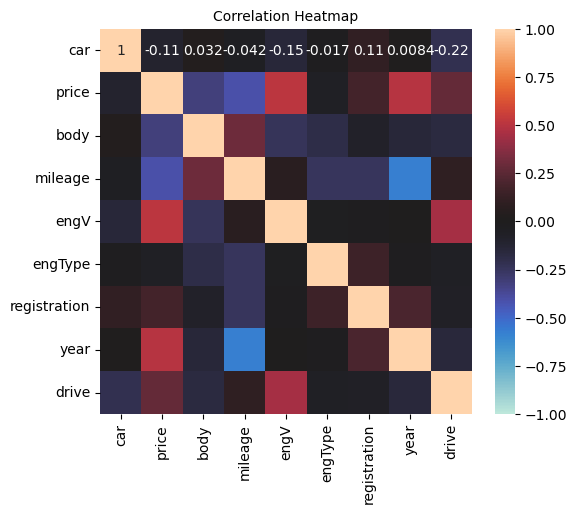

In [ ]:
corr = df.corr()
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='icefire')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10});

#### EX7: Which variables are more correlated with the target?

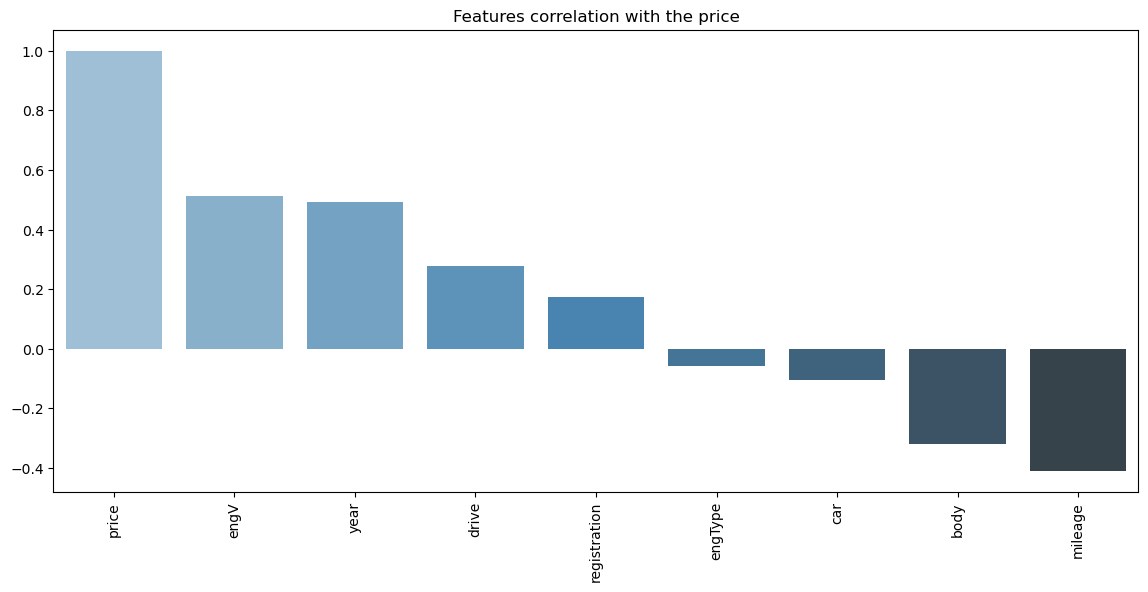

In [ ]:
corr_price = df.corr()['price'].sort_values(ascending=False)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(x=corr_price.index, y=corr_price.values, palette="Blues_d")
plt.title('Features correlation with the price')
plt.xticks(rotation=90)
plt.show()

**Solution:** engV, year and mileage are the highest correlated variables with price.

## Model training

In [ ]:
#Let's split train and test data
X = df.drop("price", axis=1)
y = df["price"]
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

#### Ensure X and Y have the same lenght for both train and test

In [ ]:
print("Lenght X_train:",len(X_train))
print("Length y_train:", len(y_train))
print("Lenght X_test:",len(X_test))
print("Length y_test:", len(y_test))

Lenght X_train: 6168
Length y_train: 6168
Lenght X_test: 2056
Length y_test: 2056


#### Try different models:

In [ ]:
#Linear Regression:

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
display(linear_reg)

y_pred_test = linear_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

LinearRegression()

$9,344.01


In [ ]:
#Random Forest:

random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X_train, y_train)
display(random_forest_reg)

y_pred_test = random_forest_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

RandomForestRegressor(random_state=0)

$4,322.87


In [ ]:
#XGBoost:

lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit (X_train, y_train)
display(lgb_reg)

y_pred_test=lgb_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 6168, number of used features: 8
[LightGBM] [Info] Start training from score 14393.636463


LGBMRegressor()

$4,109.40


#### it seems that LightGBM performs better for this use case, so let's continue with the this algorithm grid search for choosing the best parameters (this can take some minutes):

In [ ]:
# Add as many parametrers as you want
max_depth = [2, 8, 12]
n_estimators = [50, 100, 300]
learning_rate = [0.1]

parameters = {
    "max_depth": max_depth,
    "n_estimators": n_estimators,
    "learning_rate": learning_rate}

lgb_reg = lgb.LGBMRegressor(random_state=42, force_row_wise=True)

# Grid Search
gs = GridSearchCV(lgb_reg, parameters, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 4934, number of used features: 8
[LightGBM] [Info] Start training from score 14477.580131
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 4934, number of used features: 8
[LightGBM] [Info] Start training from score 14271.986943
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 4934, number of used features: 8
[LightGBM] [Info] Start training from score 14387.008520
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 4935, number of used features: 8
[LightGBM] [Info] Start training from score 14407.830177
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 4935, number of used features: 8
[LightGBM] [Info] Start training from score 14423.767560
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 4934

GridSearchCV(estimator=LGBMRegressor(force_row_wise=True, random_state=42),
             param_grid={'learning_rate': [0.1], 'max_depth': [2, 8, 12],
                         'n_estimators': [50, 100, 300]},
             scoring='neg_mean_squared_error')

In [ ]:
lgb_reg = gs.best_estimator_
lgb_reg.fit(X_train, y_train)

y_pred_test = lgb_reg.predict(X_test)

error = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("${:,.02f}".format(error))

print("The R2_score is:", r2_score(y_test, y_pred_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 6168, number of used features: 8
[LightGBM] [Info] Start training from score 14393.636463


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
$3,854.79
The R2_score is: 0.9252673105965709


#### EX8: Test with an invented example (just run the code and answer the questions):

In [176]:
A = []
Q = [
    "Enter your brand car "+  str(list(df_original['car'].unique()[:5]))[:-1]+" , ...]: ",
    "Enter the body category of your car "+ str(list(df_original['body'].unique()))+': ',
    "Enter the milage: ",
    "Enter the engV (use '.' as decimal): ",
    "Enter the engType "+ str(list(df_original['engType'].unique()))+': ',
    "Enter if it registered (yes/no): ",
    "Enter the year of the car: ",
    "Enter the drive type of the car "+ str(list(df_original['drive'].unique()))+': ']

for q in Q:
    a = input(q)
    A.append(a)

print("Your answers are:", A)

Your answers are: ['Ford', 'van', '11', '1.0', 'Diesel', 'no', '1600', 'rear']


In [177]:
X_sample = np.array([A])

# Apply the encoder and data type corrections:
X_sample[:, 0] = str(X_sample[:, 0][0] if X_sample[:, 0][0] in list(df_original['car'].unique()) else 'Other')
X_sample[:, 0] = le_car.transform(X_sample[:,0])
X_sample[:, 1] = le_body.transform(X_sample[:,1])
X_sample[:, 4] = le_engType.transform(X_sample[:,4])
X_sample[:, 5] = int(1 if X_sample[:, 5][0] in yes_l else 0)
X_sample[:, 7] = le_drive.transform(X_sample[:,7])

X_sample = np.array([[
    int(X_sample[0, 0]),
    int(X_sample[0, 1]),
    int(X_sample[0, 2]),
    float(X_sample[0, 3]),
    int(X_sample[0, 4]),
    int(X_sample[0, 5]),
    int(X_sample[0, 6]),
    int(X_sample[0, 7])
]])

print('The encoded array is: ', X_sample)

The encoded array is:  [[1.3e+01 5.0e+00 1.1e+01 1.0e+00 0.0e+00 0.0e+00 1.6e+03 2.0e+00]]


In [178]:
y_pred_sample = lgb_reg.predict(X_sample)
print("Your car estimated price is: ","${:,.02f}".format(y_pred_sample[0]))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Your car estimated price is:  $-37.18


### Store and read the model

In [179]:
# Store
data = {"model": lgb_reg, "le_car": le_car, "le_body": le_body, "le_engType":le_engType , "le_drive":le_drive}
with open('model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [181]:
# Read
with open('model.pkl', 'rb') as file:
    data = pickle.load(file)

model = data["model"]
le_car = data["le_car"]
le_body = data["le_body"]
le_engType = data["le_engType"]
le_drive = data["le_drive"]

y_pred_sample = model.predict(X_sample)
print("Your car estimated price is: ","${:,.02f}".format(y_pred_sample[0]))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Your car estimated price is:  $-37.18


## Explainability AI

As an excellent data scientist, we cannot conclude our work without understanding how the model works. In this section of the project, we will apply SHAP as a technique to understand, debug and explain our model.

### Global explainability

#### EX9: Train a Shap explainer and calculate the shap_values object for the X_test dataset. Print the shap values object of the first sample of X_test.

In [207]:
import shap

shap.initjs()
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

display(X_test)
print(shap_values[0])


 99%|===================| 2034/2056 [00:12<00:00]        

,car,body,mileage,engV,engType,registration,year,drive
4768,27,2,350,1.8,3,1,1990,0
7720,26,1,140,1.7,1,1,2007,0
4300,29,3,285,1.6,3,1,2001,0
8408,12,5,110,1.9,0,1,2008,0
2919,43,3,330,2.8,1,1,1994,0
...,...,...,...,...,...,...,...,...
3776,35,1,91,1.8,3,1,2011,0
7335,43,2,10,1.6,0,1,1984,2
5725,43,3,102,1.8,3,1,2011,0
4667,3,3,400,2.8,3,1,1998,2


.values =
array([ -301.37632308,  -106.83672633,  -666.20256309,  -244.91473192,
          74.90739225,    47.7806849 , -7419.19664168,  -377.40466124])

.base_values =
11974.468337506503

.data =
array([2.70e+01, 2.00e+00, 3.50e+02, 1.80e+00, 3.00e+00, 1.00e+00,
       1.99e+03, 0.00e+00])


#### EX10: Which is the average price cost prediction for all cars?

In [208]:
predicted_prices_train = model.predict(X_train)
predicted_prices_test = model.predict(X_test)

average_predicted_price_train = predicted_prices_train.mean()
average_predicted_price_test = predicted_prices_test.mean()

average_predicted_price = np.mean([average_predicted_price_train, average_predicted_price_test])

print(f"The average predicted price for all cars is: {average_predicted_price}")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
The average predicted price for all cars is: 14061.987992477756


**Solution:** $14,061.987992477756

#### Let's plot the summary plot and bar plot for global explainability of the model.

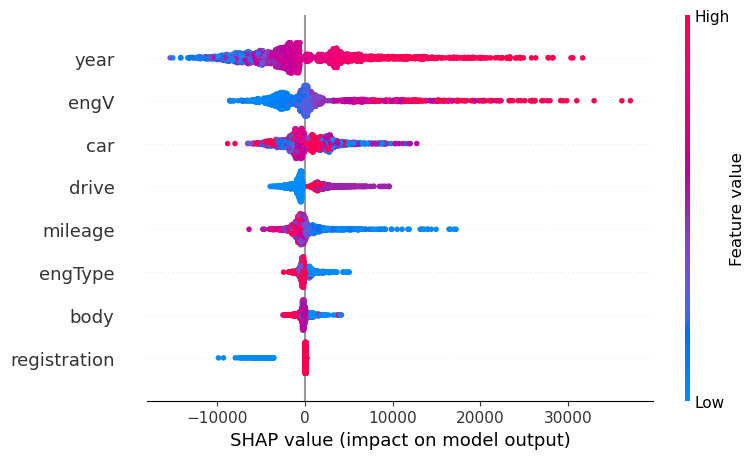

In [209]:
#Global Explainability
# type(shap_values)
shap.summary_plot(shap_values, X_test)

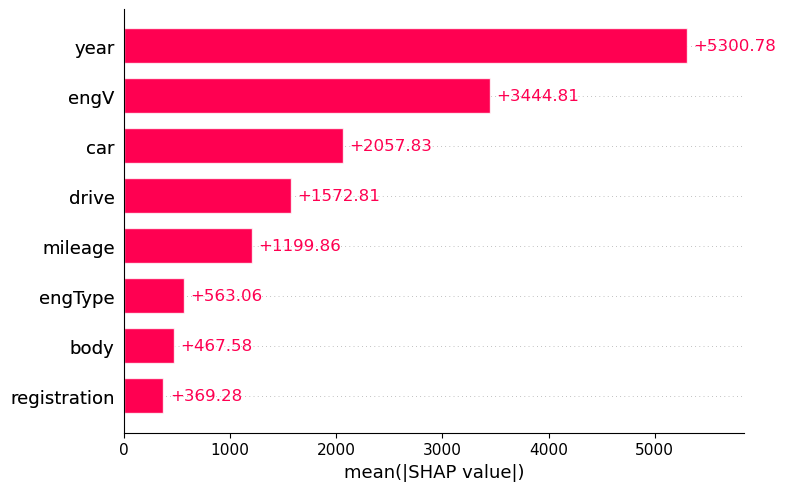

In [210]:
#Plot var: built from column 1 of all shap_values
shap.plots.bar(shap_values)

#### EX11: Which are your insights?

### Insights:

**Year:** The ‘year’ feature has the highest impact on the model’s output. This could indicate that the age of the car is a critical factor in its price. Interestingly, the spread of SHAP values for this feature is quite wide, suggesting that the model has learned complex, non-linear relationships between the car’s age and its price.

**EngV:** The ‘EngV’ or engine volume also significantly influences the model’s predictions. The positive correlation suggests that cars with larger engines tend to be more expensive. However, the presence of both high and low SHAP values for the same feature values indicates that other features may interact with ‘EngV’ to determine the price.

**Car:** The ‘car’ feature likely represents the car’s make or model. The wide spread of SHAP values for this feature suggests that certain car models are associated with higher prices, while others are associated with lower prices. This could reflect the market’s perception of different car brands and models.

**Drive, Mileage, EngType**: These features show a moderate impact on the model’s output. The specific impact would depend on the values of these features. For instance, cars with higher mileage might be priced lower due to wear and tear. Similarly, the type of engine and drive could reflect the car’s performance characteristics, which could influence its price.

**Registration, Body**: These features have the least impact on the model’s output. However, their presence in the model suggests that they do contribute some information to the predictions. For example, the registration status could indicate whether the car is road-legal, while the body type could reflect the car’s suitability for different uses (e.g., a sedan for city driving vs. an SUV for off-road use).

The color gradient in the plot provides additional insights. For instance, for the ‘year’ feature, points that are colored pink (representing recent years) are associated with higher SHAP values. This suggests that newer cars tend to have higher prices, which aligns with real-world expectations.

#### Let's do deep dive in the variables `Mileage`, `engV` and `year`. 

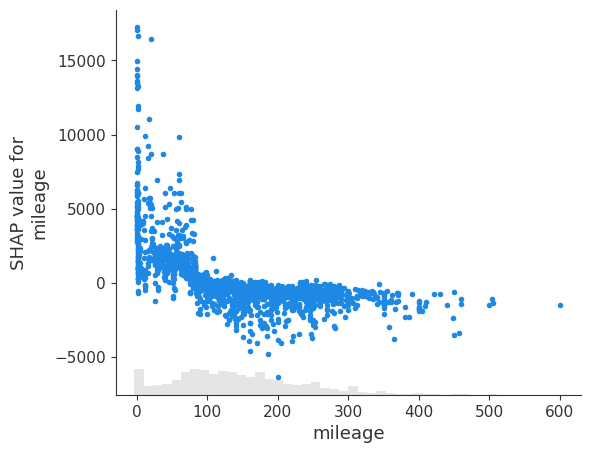

In [211]:
shap.plots.scatter(shap_values[:,"mileage"])

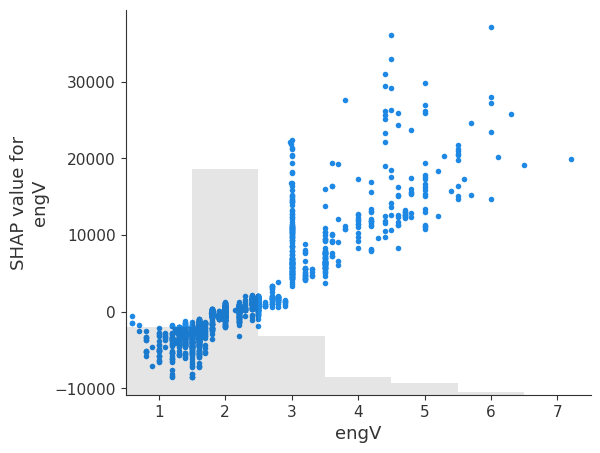

In [212]:
shap.plots.scatter(shap_values[:,"engV"])

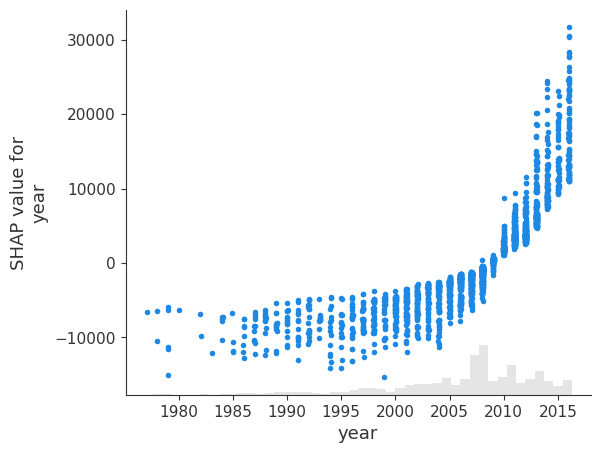

In [213]:
shap.plots.scatter(shap_values[:,"year"])

#### EX12: What are the most relevant insights abour the evolution of the features' values and their Shap values.

#### **Solution:**

**Engine Volume (engV):** Larger engine volumes are generally associated with higher car prices. There’s a significant cluster around engV values of 4 and 5, suggesting these values are particularly important for the model.

**Mileage:** Higher mileage values are generally associated with lower car prices. The model seems to penalize cars with higher mileage.

**Year:** Newer cars are generally associated with higher prices. The importance of the year feature in predicting car prices has increased over time.

#### Let's analyze the relationship of the variables `engV` and `year` and their Shap values according to the value of `mileage`.

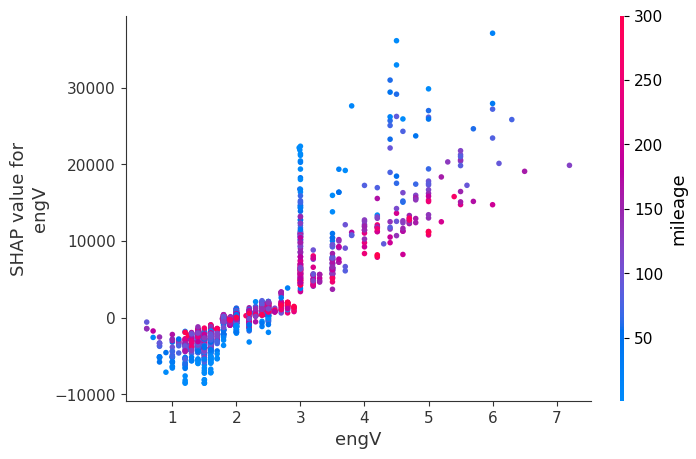

In [214]:
#Let's analyze the evolution of Shap values of engV based on mileage
shap.dependence_plot("engV", shap_values.values, X_test, interaction_index= "mileage")

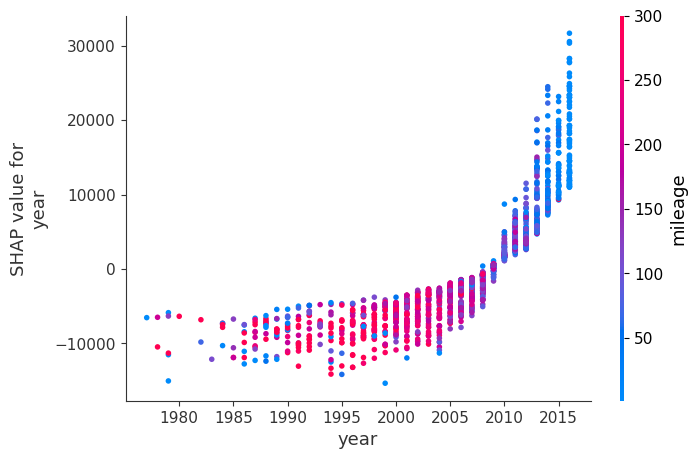

In [215]:
#Let's analyze the evolution of Shap values of engV based on mileage
shap.dependence_plot("year", shap_values.values, X_test, interaction_index= "mileage")

 #### EX13: What are the most relevant insights about the evolution of the features' values and their Shap values.

**Solution:**

From the scatter plot, it appears that there is a positive relationship between the variables year and their Shap values. This suggests that as the year value increases, the Shap value also increases, indicating that year has a strong positive effect on the predicted car prices.

The data points are colored according to the value of mileage, with blue representing lower values and pink representing higher values. This color coding allows us to see how mileage affects the relationship between year and the Shap values.

The data points form a curved line, with the Shap values for year increasing as the value of mileage increases. This suggests that cars with higher mileage tend to be older, and this is reflected in their Shap values.

In terms of model explainability, this analysis suggests that year is an important feature for predicting car prices, as it has a strong positive effect on the predictions. The mileage feature also seems to play a role, as indicated by the color coding of the data points, but its effect is less clear from this plot alone. You might want to investigate the relationship between mileage and the predicted car prices further, perhaps by looking at the Shap values for mileage specifically.

To summarize, both engV and year appear to be important features for predicting car prices, with higher values of both variables being associated with higher Shap values. The mileage feature also seems to play a role, but its effect is less clear from these plots alone. Further investigation of the relationship between mileage and the predicted car prices might be beneficial for improving your model.

### Local explainability

Local explainability facilitates the understanding of the prediction for some particular cases. In other words, XAI closes to a personalized prediction explainability. Let's use the first sample of X_test for the following steps.

#### Using the waterfall, force and decision plots, we can explain how the model works.

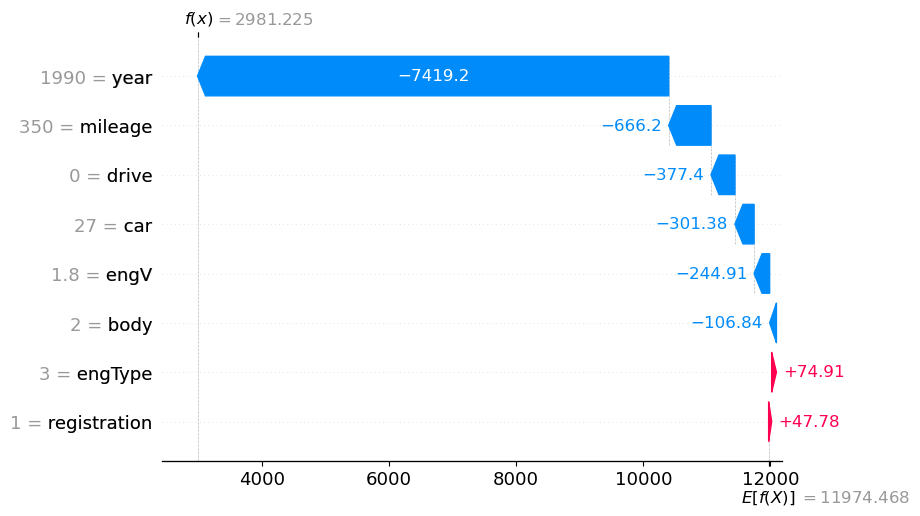

In [216]:
shap.plots.waterfall(shap_values[0])

In [217]:
shap.plots.force(shap_values[0])

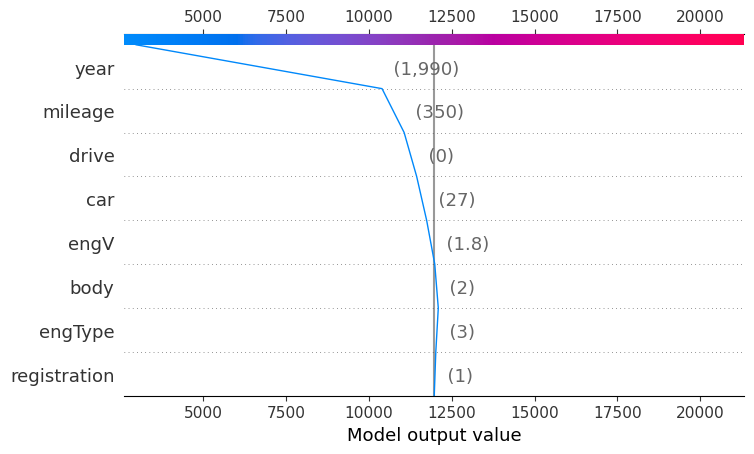

In [218]:
shap.decision_plot(shap_values[0].base_values,shap_values[0].values, X_test.iloc[0])